## Scaling, Accuracy Example

---

In this notebook, speed comparisons between the BAPE algorithm and the "brute force" method of just using your forward model for Bayesian parameter inference using MCMC (see https://github.com/dfm/emcee for our MCMC algorithm).  We run the BAPE algorithm on the Wang & Li (2017) Rosenbrock function example and consider cases where instead of the ${\sim}10\mu$s runtime of the analytic Rosenbrock function, it took anywhere from $10^{-3}$s to $10^{4}$s.  This exercise allows to us crudely estimate how slow a forward model must be before using approximate methods such as ```approxposterior``` is warranted.

In [1]:
%matplotlib inline

from __future__ import (print_function, division, absolute_import,
                        unicode_literals)
from approxposterior import bp, likelihood as lh
import corner
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 18})

**Initialize and run the BAPE Algorithm example as was done in the BAPE_Example notebook.**

---

In [2]:
m0 = 20                           # Initial size of training set
m = 10                            # Number of new points to find each iteration
nmax = 20                         # Maximum number of iterations
M = int(2.0e4)                    # Number of MCMC steps to estimate approximate posterior
Dmax = 0.01                        # KL-Divergence convergence limit
kmax = 5                          # Number of iterations for Dmax convergence to kick in
which_kernel = "ExpSquaredKernel" # Which Gaussian Process kernel to use
bounds = ((-5,5), (-5,5))         # Prior bounds
algorithm = "bape"                 # Use the Kandasamy et al. (2015) formalism

In [3]:
ap = bp.ApproxPosterior(lnprior=lh.rosenbrock_lnprior,
                        lnlike=lh.rosenbrock_lnlike,
                        prior_sample=lh.rosenbrock_sample,
                        algorithm=algorithm)

**This time, turn on the timing option with timing=True in the run method.**

---

Setting ```timing=True``` allows the code to profile how long various parts of the algorithm take to run.  If ```timing=True```, then the code keeps track of, for each iteration, how long it takes to find/retrain the Gaussian Process for the $m$ new design points, run the MCMC, fit the Gaussian Mixture Model approximation to the joint posterior distribution, and estimate the KL divergence between the current and previous joint posterior distributions.

In [5]:
# Run!
ap.run(m0=m0, m=m, M=M, nmax=nmax, Dmax=Dmax, kmax=kmax,
       bounds=bounds, which_kernel=which_kernel,
       n_kl_samples=100000, verbose=False,
       timing=True)

/Users/dflemin3/approxposterior/approxposterior/utility.py:93: RuntimeWarning: invalid value encountered in log
  res = np.sum(np.log(p(x)/q(x)))/len(x)
/Users/dflemin3/approxposterior/approxposterior/utility.py:93: RuntimeWarning: invalid value encountered in log
  res = np.sum(np.log(p(x)/q(x)))/len(x)


**Estimate Time Scaling as a Function of Forward Model Time**

---

Now, we're going to pretend that our forward model takes anywhere $10^{-5}$s to $10^{4}$s for one evaluation.  In the "brute force" method, for each iteration for each walker, the MCMC algorithm runs the forward model, typically resulting in $>10^5$ forward model evaluations!  Obviously for slow forward models, this readily becomes computationaly intractible (unless you're willing to wait PhD timescales for it to finish!).  Here, we show how the "brute force" method fairs compared to ```approxposterior```'s BAPE implementation.  In this section, we take care to accurately time all facets of the algorithm while factoring in different forward model evaluation times.

In [6]:
# Create synthetic forward model times in seconds
ns = np.logspace(-5,4,10)

# Number of evluations in the MCMC chain
niters = len(ap.samplers[-1].flatchain)

# "Brute force" times are the number of evaluations times the forward model evaluation time
brute_times = ns*niters

In [7]:
# Compute GP training time factoring in synthetic forward model run times
gp_times = np.zeros(len(ns))

for ii in range(len(ns)):
    # The algorithm initializes with m0 forward model evaluations
    gp_times[ii] = m0*ns[ii]
    
    # Loop over iterations
    for jj in range(len(ap.training_time)):
        # Add time of running forward model to get m new points and training GP, running mcmc, 
        # change in KL divergence, and GMM estimation times
        gp_times[ii] += m*ns[ii] + ap.training_time[jj] + ap.mcmc_time[jj] + ap.kl_time[jj] + ap.gmm_time[jj]

**Plot the scalings to see where both methods are faster!**

---

Below, we plot the total time it takes for the full Bayesian parameter inference (y axis) as a function of forward model evaluation time (x axis).

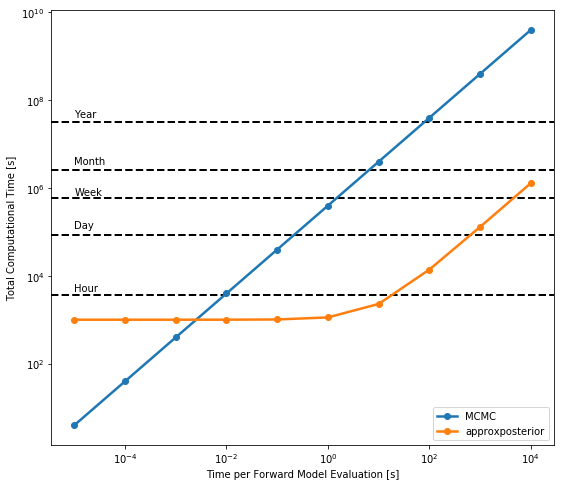

In [8]:
fig, ax = plt.subplots(figsize=(9,8))

ax.plot(ns, brute_times, "o-", lw=2.5, label="MCMC")
ax.plot(ns, gp_times, "o-", lw=2.5, label="approxposterior")

# Reference year, month, week, day, hour timescales
ax.axhline((365*24*60*60), lw=2, ls="--", color="k", zorder=0)
ax.axhline((30*24*60*60), lw=2, ls="--", color="k", zorder=0)
ax.axhline((7*24*60*60), lw=2, ls="--", color="k", zorder=0)
ax.axhline((24*60*60), lw=2, ls="--", color="k", zorder=0)
ax.axhline((60*60), lw=2, ls="--", color="k", zorder=0)

# One minute forward model reference
#ax.axvline(60, lw=2, ls=":", color="k", zorder=3)

ax.text(1.0e-5, 4.0e7, "Year")
ax.text(1.0e-5, 3.5e6, "Month")
ax.text(1.0e-5, 7.0e5, "Week")
ax.text(1.0e-5, 1.2e5, "Day")
ax.text(1.0e-5, 4.4e3, "Hour")

ax.set_ylabel("Total Computational Time [s]")
ax.set_xlabel("Time per Forward Model Evaluation [s]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="lower right")

fig.savefig("scaling.pdf", bbox_inches="tight")

There are two clear regimes in this figure.  For very fast forward models, $t<10^{-2}$s per evaluation, it's slower to train the Gaussian process then actually run the MCMC using the true forward model, so in this case it's not worth using approximate methods.  For slow forward models, $t>10$s per model evaluation, most of the time is spent running the forward model to give training points to the Gaussian process, so the actual MCMC inference is relatively computationally cheap (GP predictions take of order milliseconds!).

The turnover when it's faster to use ```approxposterior``` occurs once the forward model takes ${\sim}10^{-2}$s to run.  At that point, however, it takes of order minutes to run the entire parameter inference, so there is no practical gain.  Once the forward model takes a few minutes to run, however, the approximate method completes in of order hours while the brute force method can take up to a month -- a massive speed-up! 

Strictly speaking, this scaling plot applies to the Rosenbrock function example from Wang & Li (2017).  Scaling plots like the one above depend on how many MCMC iterations you use, the MCMC algorithm, how many samples the GP is trained on, and probably the GP kernel.  For example, longer MCMCs have a raised floor for the flat region of the GP approximation curve and dictate when the turnover occurs.

**For slow forward models, the approximate methods are clearly faster.  But how accurate are the results?**

---

Above, we used the exact algorithm parameters Wang & Li (2017) used for their Rosenbrock function example.  In the True_Rosenbrock_Posterior example notebook, we ran an MCMC inference using the true Rosenbrock function likelihood and algorithm parameters from Wang & Li (2017) to derive the "true" joint posterior distribution.  Below, we visually and numerically compare the approximation to the joint posterior distribution derived above with true distribution to see how accurate the approximate method is.

In [9]:
# Load in the true chains from the True_Rosenbrock_Posterior example notebook
true_mcmc = np.load("true_rosenbrock.npz")
true_flatchain = true_mcmc["flatchain"]
true_iburn = true_mcmc["iburn"]

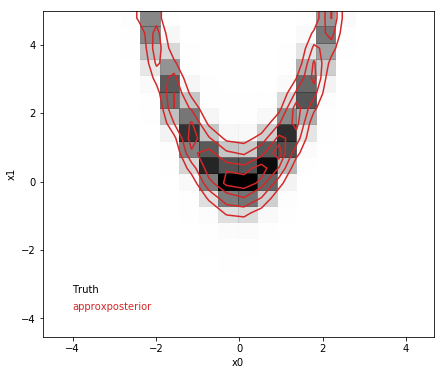

In [10]:
fig, ax = plt.subplots(figsize=(7,6))

bins = 20

# Plot GP approximation to the joint distribution
corner.hist2d(ap.samplers[-1].flatchain[ap.iburns[-1]:,0], ap.samplers[-1].flatchain[ap.iburns[-1]:,1], 
              bins=bins, ax=ax, color="C3", plot_density=False, plot_contours=True, plot_datapoints=False,
             label="GP Approximation")

# Plot the true joint distribution
corner.hist2d(true_flatchain[true_iburn:,0], true_flatchain[true_iburn:,1], bins=bins,
              ax=ax, color="black", plot_density=True, plot_contours=False, plot_datapoints=False)

# Formating
ax.text(-4, -3.25, "Truth", color="black")
ax.text(-4, -3.75, "approxposterior", color="C3")
ax.set_xlabel("x0")
ax.set_ylabel("x1")

fig.savefig("accuracy.pdf", bbox_inches="tight")

The true and approximate distributions look nearly identical!  How do the 0.16, 0.5, 0.84 quantiles compare for the 2 parameters, x0 and x1? 

In [11]:
approx_x0 = np.percentile(ap.samplers[-1].flatchain[ap.iburns[-1]:,0],[0.16, 0.5, 0.84])
approx_x1 = np.percentile(ap.samplers[-1].flatchain[ap.iburns[-1]:,1],[0.16, 0.5, 0.84])

true_x0 = np.percentile(true_flatchain[true_iburn:,0],[0.16, 0.5, 0.84])
true_x1 = np.percentile(true_flatchain[true_iburn:,1],[0.16, 0.5, 0.84])

In [12]:
print("x0")
print("True\t", true_x0)
print("Approx\t", approx_x0)
print("")
print("x1")
print("True\t", true_x1)
print("Approx\t", approx_x1)

x0
True	 [-2.42413897 -2.33275974 -2.28254016]
Approx	 [-2.42484547 -2.33749995 -2.28117429]

x1
True	 [-1.70409114 -1.40815878 -1.25679066]
Approx	 [-1.68933065 -1.39445995 -1.24672184]


Looks good, but let's visualize this instead...

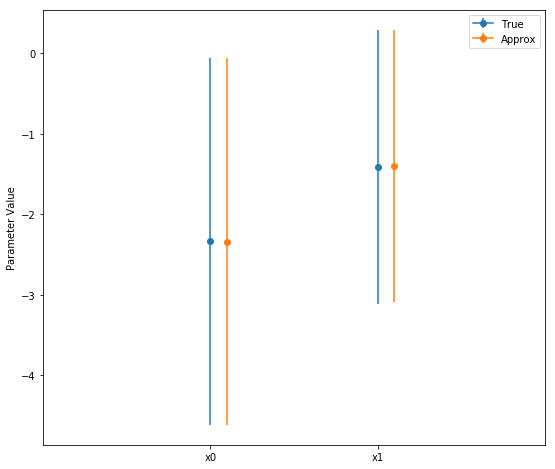

In [13]:
fig, ax = plt.subplots(figsize=(9,8))

# True, approx x0
ax.errorbar([0], [true_x0[1]], yerr=[(true_x0[2], true_x0[0])], fmt='-o', color="C0", label="True")
ax.errorbar([0.1], [approx_x0[1]], yerr=[(approx_x0[2], approx_x0[0])], fmt='-o', color="C1", label="Approx")

# True, approx x1
ax.errorbar([1], [true_x1[1]], yerr=[(true_x1[0], true_x1[2])], fmt='-o', color="C0")
ax.errorbar([1.1], [approx_x1[1]], yerr=[(approx_x1[0], approx_x1[2])], fmt='-o', color="C1")

# Format
xticks = [0, 1]
labels = ["x0", "x1"]
ax.set_xticks(xticks)
ax.set_xticklabels(labels)

ax.set_xlabel("")
ax.set_ylabel("Parameter Value")
ax.set_xlim(-1,2)
ax.legend(loc="best")

The answers are consistent and nearly identical - great!

**Plot them together**

---

Good for posters and stuff.

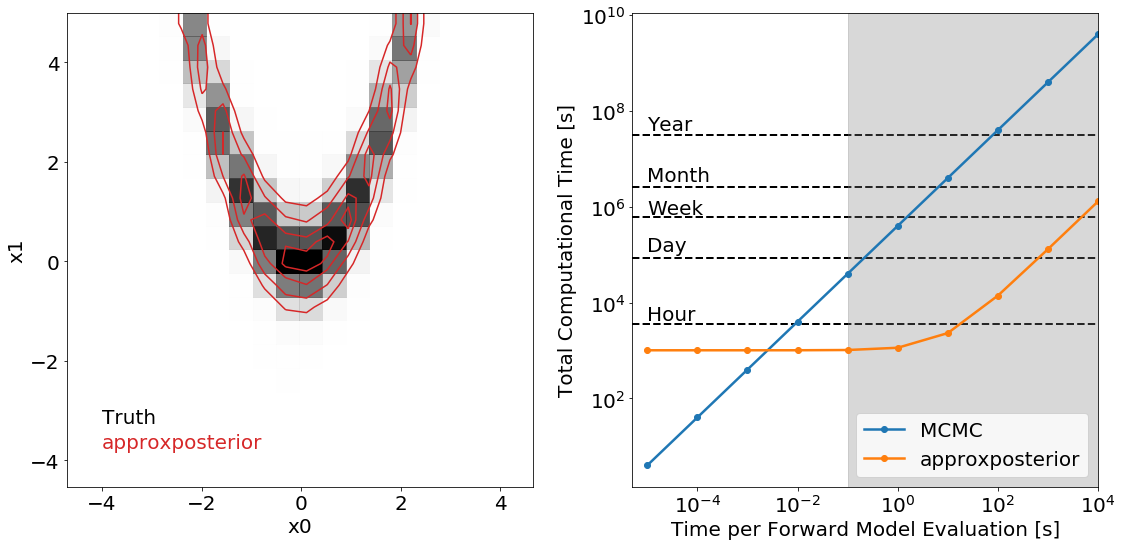

In [20]:
mpl.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(ncols=2, figsize=(16,8))

# Left: Accuracy
bins = 20

# Plot GP approximation to the joint distribution
corner.hist2d(ap.samplers[-1].flatchain[ap.iburns[-1]:,0], ap.samplers[-1].flatchain[ap.iburns[-1]:,1], 
              bins=bins, ax=ax[0], color="C3", plot_density=False, plot_contours=True, plot_datapoints=False,
             label="GP Approximation")

# Plot the true joint distribution
corner.hist2d(true_flatchain[true_iburn:,0], true_flatchain[true_iburn:,1], bins=bins,
              ax=ax[0], color="black", plot_density=True, plot_contours=False, plot_datapoints=False)

# Formating
ax[0].text(-4, -3.25, "Truth", color="black")
ax[0].text(-4, -3.75, "approxposterior", color="C3")
ax[0].set_xlabel("x0")
ax[0].set_ylabel("x1")

# Right: Scaling
ax[1].plot(ns, brute_times, "o-", lw=2.5, label="MCMC")
ax[1].plot(ns, gp_times, "o-", lw=2.5, label="approxposterior")

# Reference year, month, week, day, hour timescales
ax[1].axhline((365*24*60*60), lw=2, ls="--", color="k", zorder=0)
ax[1].axhline((30*24*60*60), lw=2, ls="--", color="k", zorder=0)
ax[1].axhline((7*24*60*60), lw=2, ls="--", color="k", zorder=0)
ax[1].axhline((24*60*60), lw=2, ls="--", color="k", zorder=0)
ax[1].axhline((60*60), lw=2, ls="--", color="k", zorder=0)

# Shade region or typical vplanet runtimes
ax[1].axvspan(0.1, 1.0e4, color='grey', alpha=0.3)

ax[1].text(1.0e-5, 4.0e7, "Year")
ax[1].text(1.0e-5, 3.5e6, "Month")
ax[1].text(1.0e-5, 7.0e5, "Week")
ax[1].text(1.0e-5, 1.2e5, "Day")
ax[1].text(1.0e-5, 4.4e3, "Hour")

ax[1].set_ylabel("Total Computational Time [s]")
ax[1].set_xlabel("Time per Forward Model Evaluation [s]")
ax[1].set_xlim(5.0e-6,1.0e4)
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].legend(loc="lower right")

fig.tight_layout()

fig.savefig("acc_scal_shaded.pdf", bbox_inches="tight")